# Exercise 11.1 - Solution
## Air-shower reconstruction
Follow the description of a cosmic-ray observatory in Example 11.2 and Fig. 11.2(b).
The simulated data contain 9 × 9 detector stations which record traversing particles from the cosmic-ray induced air shower.  
Each station measures two quantities, which are stored in the form of a map (2D array) corresponding to the station positions in offset coordinates:
- arrival time `T`: time point of detection in seconds
- signal `S`: signal strength in arbitrary units

The following shower properties need to be reconstructed:
- `axis`: x, y, z unit vector of the shower arrival direction
- `core`: position of the shower core in meters
- `logE`: $\log_{10} (E / \mathrm{eV})$, energy of the cosmic ray

Reconstruct the properties of the arriving cosmic rays by analyzing their
air showers:

### Tasks 
1. Set up a multi-task regression network for simultaneously predicting shower direction, shower core position, and energy. The network should consist of a common part to the three properties, followed by an individual subnetwork for each property. Combine the mean squared errors of the different properties using weights $w_j$.  


2. Train the model to the following precisions:
- Better than $1.5^\circ$ angular resolution
- Better than $25$ m core position resolution
- Better than $7\%$ relative energy uncertainty $\left(\frac{E_\mathrm{pred} - E_\mathrm{true}}{E_\mathrm{true}}\right)$

  Estimate what these requirements mean in terms of the mean squared error loss and adjust the relative weights in the objective function accordingly.  

3. Plot and interpret the resulting training curves, both with and without the weights $w_j$ in the objective function.

##### Hint: using a GPU for this task may be advantageous!

In [24]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

layers = keras.layers



keras version 2.4.0


### Download data

In [2]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1nQDddS36y4AcJ87ocoMjyx46HGueiU6k"
output = 'airshowers.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output)

### Input 1: arrival times

In [3]:
# time map
T = f['time']
T -= np.nanmean(T)
T /= np.nanstd(T)
T[np.isnan(T)] = 0

print(T.shape)

(200000, 9, 9)


#### Plot four example arrival time maps

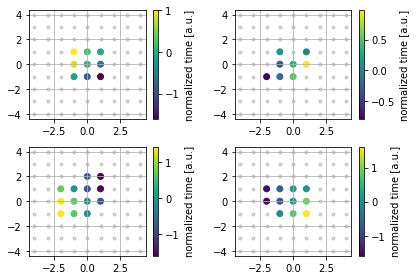

In [4]:
nsamples=len(T)
random_samples = np.random.choice(nsamples, 4)

def rectangular_array(n=9):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)


for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=T[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], 
                          cmap="viridis", alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized time [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Input 2: signals

In [5]:
# signal map
S = f['signal']
S = np.log10(1 + S)
S -= np.nanmin(S)
S /= np.nanmax(S)
S[np.isnan(S)] = 0

print(S.shape)

(200000, 9, 9)


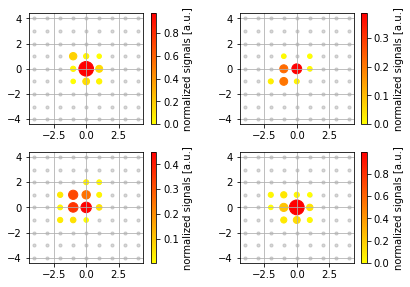

In [6]:
for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=S[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 200 * footprint[mask] + 20
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], s=marker_size,
                          cmap="autumn_r", alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized signals [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

Combine inputs

In [7]:
X = np.stack([T, S], axis=-1)

### Labels

In [8]:
axis = f['showeraxis']

In [9]:
core = f['showercore'][:, 0:2]
core /= 750

In [10]:
# energy - log10(E/eV) in range [18.5, 20]
logE = f['logE']
logE -= 19.25

In [11]:
X_train, X_test = np.split(X, [-20000])
axis_train, axis_test = np.split(axis, [-20000])
core_train, core_test = np.split(core, [-20000])
logE_train, logE_test = np.split(logE, [-20000])

## Define Model
## Task 
Set up a multi-task regression network for simultaneously predicting shower direction, shower core position, and energy. The network should consist of a common part to the three properties, followed by an individual subnetwork for each property.

In [12]:
# define towers for the individual targets
def tower(z, nout, name):
    zt = layers.Conv2D(32, (3, 3), name=name + '-conv1', **kwargs)(z)
    zt = layers.Conv2D(32, (3, 3), name=name + '-conv2', **kwargs)(zt)
    zt = layers.Conv2D(48, (3, 3), name=name + '-conv3', **kwargs)(zt)
    zt = layers.Flatten(name=name + '-flat')(zt)
    zt = layers.Dense(10 * nout, name=name + '-dense', **kwargs)(zt)
    return layers.Dense(nout, name=name)(zt)

In [13]:
input1 = layers.Input(shape=(9, 9, 2))

kwargs = dict(activation='relu', kernel_initializer='he_normal')

z = layers.SeparableConv2D(8, (3, 3), padding="same", **kwargs)(input1)

# common densely connected block
zlist = [z]
for i in range(5):
    z = layers.Conv2D(16, (1, 1), padding='same', **kwargs)(z)
    z = layers.SeparableConv2D(16, (3, 3), padding='same', **kwargs)(z)
    zlist.append(z)
    z = layers.concatenate(zlist[:], axis=-1)

z1 = tower(z, 3, 'axis')
z2 = tower(z, 2, 'core')
z3 = tower(z, 1, 'energy')

model = keras.models.Model(inputs=[input1], outputs=[z1, z2, z3])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 2)]    0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 9, 9, 8)      42          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 16)     144         separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 9, 9, 16)     416         conv2d[0][0]                     
______________________________________________________________________________________________

### Task
Train the model to the following precisions:
- Better than $1.5^\circ$ angular resolution
- Better than $25$ m core position resolution
- Better than $7\%$ relative energy uncertainty $\left(\frac{E_\mathrm{pred} - E_\mathrm{true}}{E_\mathrm{true}}\right)$  
  Estimate what these requirements mean in terms of the mean squared error loss and adjust the relative weights in the objective function accordingly.  


<em>The total objective function is $\mathcal{L}_\mathrm{tot} = w_1 \cdot \mathcal{L}_1 + w_2 \cdot \mathcal{L}_2 + w_3 \cdot \mathcal{L}_3$, where $\mathcal{L}$ are the mean squared error (MSE) objectives of the reconstruction tasks for the arrivaldirection, core position and energy, respectively.

#### shower axis
$\mathcal{L}_1 = \frac{1}{N} \sum_i^N ( \vec{a}_{\mathrm{pred},i} - \vec{a}_{\mathrm{true},i} )^2$,  
where the $\vec{a}$ vectors denote the (unit) shower axis (x,y,z).

#### shower core
$\mathcal{L}_2  = \frac{1}{N} \sum_i^N \left( \frac{\vec{c}_{\mathrm{pred},i} - \vec{c}_{\mathrm{true},i}}{750\mathrm{m}}\right)^2$,  
with $\vec{c}$ denote the 2D core position / 750 m.

#### energy
$\mathcal{L}_3 = \frac{1}{N} \sum_i^N \left( \log_{10}\frac{E_{\mathrm{pred},i}}{10^{19.25} \mathrm{eV}} - \log_{10}\frac{E_{\mathrm{true},i}}{10^{19.25} \mathrm{eV}}\right)^2$

Since the objectives can be solved to different precision, we need to apply
individual weights, such that
$\mathcal{L}_\mathrm{tot} = w_1 \cdot \mathcal{L}_1 + w_2 \cdot \mathcal{L}_2 + w_3 \cdot \mathcal{L}_3$.
We can derive the weights from the correspondence between the MSE and the negative log-likelihood for a Gaussian distribution.  

$-2 \ln(\mathcal{J}_\mathrm{tot}) = -2\cdot\ln(\mathcal{J}_1) - 2\cdot\ln(\mathcal{J}_2) - 2\cdot\ln(\mathcal{J}_3)$  
$-2 \ln(\mathcal{L}_\mathrm{tot}) = \frac{N\cdot\mathcal{L}_1 }{\sigma_1^{2}} + \frac{N\cdot\mathcal{L}_2 }{\sigma_2^{2}} + \frac{N\cdot\mathcal{L}_3}{\sigma_3^{2}}$  
$-2 \ln(\mathcal{L}_\mathrm{tot}) = w_1 \cdot \mathcal{L}_1 + w_2 \cdot \mathcal{L}_2 + w_3 \cdot \mathcal{L}_3$,  
where the number of samples $N$ is irrelevant for the optimum parameters.

Hence, the weights according to the specified resolutions read:
##### arrival direction: $$w_1 \sim 1/\sigma_1^2 = 1/(1.5^\circ)^2 ~\sim 1500$$
##### core position:     $$w_2 \sim 1/\sigma_2^2 \sim 1/(25m/750m)^2 \sim 900$$
##### energy:            $$w_3 \sim 1/\sigma_3^2 = 1/(7\%)**2 = 50$$
or simply $w_1 = 15,\;w_2 = 9,\; w_3 = 1$.

Alternatively to this calculation, we can monitor the training loss and adjust
the weights such that the contribution to the total objective is similar for all
objectives.</em>

In [14]:
loss_weights=[15, 9, 2]

model.compile(
    loss=['mse', 'mse', 'mse'],
    loss_weights=loss_weights,
    optimizer=keras.optimizers.Adam(lr=1e-3))

In [15]:
fit = model.fit(
    X_train,
    [axis_train, core_train, logE_train],
    batch_size=128,
    epochs=40,
    verbose=2,
    validation_split=0.1,
    callbacks=[keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=10, verbose=1),
               keras.callbacks.EarlyStopping(patience=5, verbose=1)]
)

Epoch 1/40
1266/1266 - 86s - loss: 0.1231 - axis_loss: 0.0033 - core_loss: 0.0065 - energy_loss: 0.0076 - val_loss: 0.0215 - val_axis_loss: 7.0796e-04 - val_core_loss: 8.4911e-04 - val_energy_loss: 0.0016
Epoch 2/40
1266/1266 - 90s - loss: 0.0184 - axis_loss: 5.5893e-04 - core_loss: 7.7077e-04 - energy_loss: 0.0015 - val_loss: 0.0158 - val_axis_loss: 3.9367e-04 - val_core_loss: 8.4929e-04 - val_energy_loss: 0.0011
Epoch 3/40
1266/1266 - 89s - loss: 0.0131 - axis_loss: 3.4936e-04 - core_loss: 6.1356e-04 - energy_loss: 0.0012 - val_loss: 0.0138 - val_axis_loss: 3.3478e-04 - val_core_loss: 6.5218e-04 - val_energy_loss: 0.0014
Epoch 4/40
1266/1266 - 84s - loss: 0.0107 - axis_loss: 2.6719e-04 - core_loss: 5.0865e-04 - energy_loss: 0.0010 - val_loss: 0.0087 - val_axis_loss: 2.2596e-04 - val_core_loss: 3.9338e-04 - val_energy_loss: 8.7309e-04
Epoch 5/40
1266/1266 - 85s - loss: 0.0095 - axis_loss: 2.2215e-04 - core_loss: 4.6645e-04 - energy_loss: 9.9106e-04 - val_loss: 0.0088 - val_axis_loss: 

### Plot training curves

In [16]:
def plot_history(history, weighted=False):
    fig, ax = plt.subplots(1)
    n = np.arange(len(history['loss']))
    for i, s in enumerate(['axis', 'core', 'energy']):
        w = loss_weights[i] if weighted else 1
        l1 = w * np.array(history['%s_loss' % s])
        l2 = w * np.array(history['val_%s_loss' % s])
        color = 'C%i' % i
        ax.plot(n, l1, c=color, ls='--')
        ax.plot(n, l2, c=color, label=s)

    ax.plot(n, history['loss'], ls='--', c='k')
    ax.plot(n, history['val_loss'], label='sum', c='k')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Weighted Loss' if weighted else 'Loss')
    ax.legend()
    ax.semilogy()
    ax.grid()
    plt.show()

#### Unweighted losses

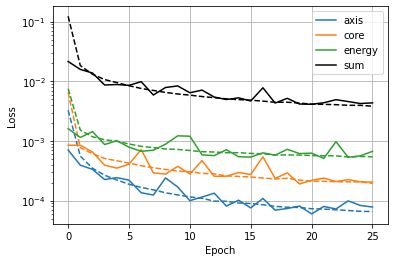

In [17]:
plot_history(fit.history, weighted=False)

#### Weighted losses

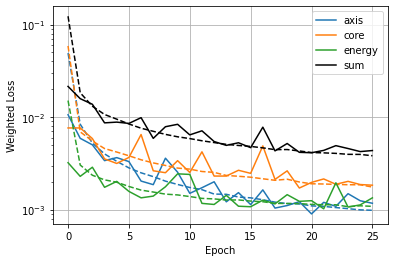

In [18]:
plot_history(fit.history, weighted=True)

## Study performance of the DNN

In [19]:
axis_pred, core_pred, logE_pred = model.predict(X_test, batch_size=128, verbose=1)
logE_pred = logE_pred[:,0]  # remove keras dummy axis

157/157 [==============================] - 3s 17ms/step


### Reconstruction performance of the shower axis

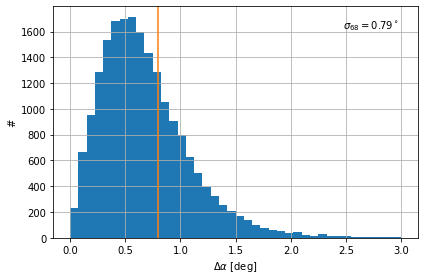

In [20]:
d = np.sum(axis_pred * axis_test, axis=1) / np.sum(axis_pred**2, axis=1)**.5
d = np.arccos(np.clip(d, 0, 1)) * 180 / np.pi
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 3, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel(r'$\Delta \alpha$ [deg]')
plt.ylabel('#')
plt.grid()
plt.tight_layout()

### Reconstruction performance of the shower core

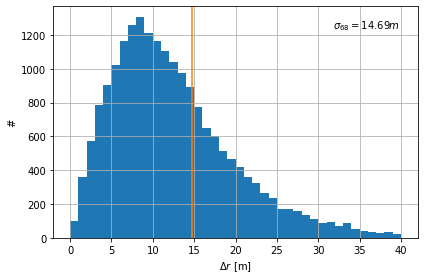

In [21]:
d = np.sum((750 * (core_test - core_pred))**2, axis=1)**.5
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 40, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f m$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel('$\Delta r$ [m]')
plt.ylabel('#')
plt.grid()
plt.tight_layout()

### Reconstruction performance of the shower energy

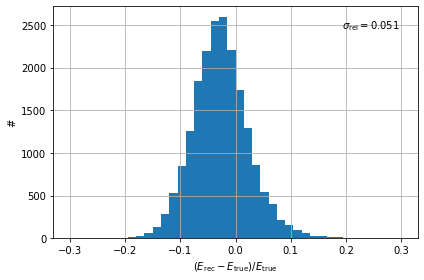

In [22]:
d = 10**(logE_pred - logE_test) - 1
reso = np.std(d)
plt.figure()
plt.hist(d, bins=np.linspace(-0.3, 0.3, 41))
plt.xlabel('($E_\mathrm{rec} - E_\mathrm{true}) / E_\mathrm{true}$')
plt.ylabel('#')
plt.text(0.95, 0.95, '$\sigma_\mathrm{rel} = %.3f$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.grid()
plt.tight_layout()

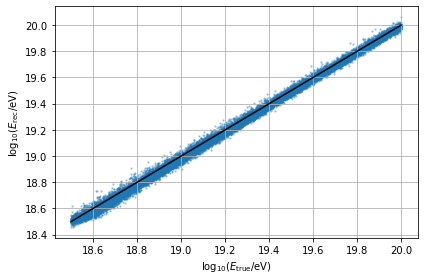

In [23]:
plt.figure()
plt.scatter(19.25 + logE_test, 19.25 + logE_pred, s=2, alpha=0.3)
plt.plot([18.5, 20], [18.5, 20], color='black')
plt.xlabel('$\log_{10}(E_\mathrm{true}/\mathrm{eV})$')
plt.ylabel('$\log_{10}(E_\mathrm{rec}/\mathrm{eV})$')
plt.grid()
plt.tight_layout()